# EDA on Walking Distance from Station Exits and Within-Mall information

## 1. Data Preparation

In [3]:
import pandas as pd
import numpy as np
import re

import geopandas as gpd #conda install geopandas
# conda install -c conda-forge nbformat

import plotly.express as px #conda install -c plotly plotly_express
from plotly.express import choropleth_mapbox
from shapely.geometry import shape, Point
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats

# python script containing mapbox token (not uploaded on GitHub)
try:
    from tokens import mapbox_token
except:
    mapbox_token = '############### USE OWN MAPBOX TOKEN ###############'
    
import warnings
warnings.filterwarnings("ignore")

### Loading of Datasets containing Features (Mall, Walking Distance, Engineered Region)

In [4]:
df_restaurant = pd.read_csv("data/extended_restaurant_rating_data.csv")
df_is_in_mall = pd.read_csv("data/restaurant_is_in_mall.csv")
df_walking_duration_from_station_exit = pd.read_csv("data/restaurant_walking_distance_from_station_exit.csv")
df_restaurant_nearest_exit = pd.read_csv('data/restaurant_nearest_station_exit.csv')
df_restaurant_new_region = pd.read_csv('data/restaurant_new_region_feature.csv')

In [5]:
subset_columns = [
    'name',
    'address',
    'latitude',
    'longitude',
    'nearby_attraction',
    'distance_from_attraction',
    'num_of_rating_1',
    'num_of_rating_2',
    'num_of_rating_3',
    'num_of_rating_4',
    'num_of_rating_5',
    'overall_rating',
    'num_of_reviews',
    'url'
]

df_restaurant_subset = df_restaurant[subset_columns].copy()

df_restaurant_subset = df_restaurant_subset.merge(df_walking_duration_from_station_exit, on='url', how='left')
df_restaurant_subset = df_restaurant_subset.merge(df_restaurant_nearest_exit[['station_name', 'station_line_color', 'url', 'distance']], on='url', how='left')
df_restaurant_subset = df_restaurant_subset.merge(df_is_in_mall[["url", "mall", "is_in_mall"]], on='url', how='left')
df_restaurant_subset = df_restaurant_subset.merge(df_restaurant_new_region, on='url', how='left')

df_restaurant_subset.dropna(subset=["new_region_feature"], inplace=True)
df_restaurant_subset.rename(columns={"new_region_feature": "region"}, inplace=True)

### Drop Missing Ratings and Number of Reviews < 3

In [6]:
df_restaurant_subset = df_restaurant_subset[
    (df_restaurant_subset['overall_rating'] != -1) &
    (df_restaurant_subset['num_of_reviews'] >= 3)
    ].copy()

In [7]:
df_restaurant_subset.sample(3)

,name,address,latitude,longitude,nearby_attraction,distance_from_attraction,num_of_rating_1,num_of_rating_2,num_of_rating_3,num_of_rating_4,...,num_of_reviews,url,walking_distance,walking_duration,station_name,station_line_color,distance,mall,is_in_mall,region
834,Knots Cafe and Living,"160 Paya Lebar Road #01-07 Orion @ Paya Lebar,...",1.329263,103.89039,NaN,NaN,4,5,11,59,...,107,https://www.tripadvisor.com.sg/Restaurant_Revi...,392.7,282.8,MACPHERSON MRT STATION,YELLOW,293.365840,NaN,0.0,GEYLANG
6976,Tsukune Ichigo,"399 River Valley Road, Singapore 248295 Singapore",1.295360,103.83018,Orchard Road,1.1,4,1,0,2,...,22,https://www.tripadvisor.com.sg/Restaurant_Revi...,1363.5,981.7,ORCHARD MRT STATION,RED,891.315214,NaN,0.0,TANGLIN
2183,Ju Shin Jung,"27 West Coast Highway #01-18/19, Yess Centre 1...",1.283333,103.78091,NaN,NaN,4,3,16,36,...,77,https://www.tripadvisor.com.sg/Restaurant_Revi...,160.9,115.9,HAW PAR VILLA MRT STATION,YELLOW,125.825020,NaN,0.0,QUEENSTOWN


### Converting Dataframe into GeoDataFrame for Geospatial EDA

In [8]:
gdf_restaurant  = gpd.GeoDataFrame(df_restaurant_subset, geometry= gpd.points_from_xy(df_restaurant_subset['longitude'], df_restaurant_subset['latitude']), crs='epsg:4326')

## 2. EDA - Walking Distance, Is In Mall

### Overall EDA on Rating Geographically

In [9]:
def percentile(n):
    '''
    Calculate Percentile
    To be used in Groupbys
    '''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [10]:
rating_dct = {
    1: 'Subpar',
    1.5: 'Subpar',
    2: 'Subpar',
    2.5: 'Subpar',
    3: 'Subpar',
    3.5: 'Subpar',
    4: 'Average',
    4.5: 'Outstanding',
    5: 'Outstanding'

}

gdf_restaurant['overall_rating_categorical'] = gdf_restaurant['overall_rating'].map(rating_dct)

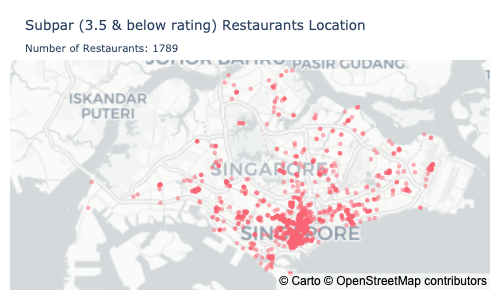

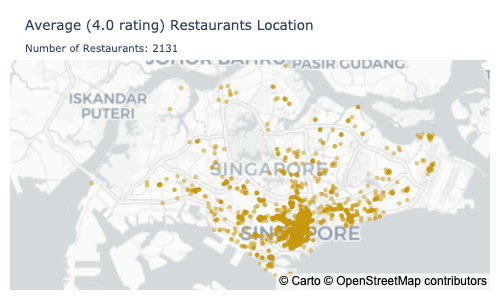

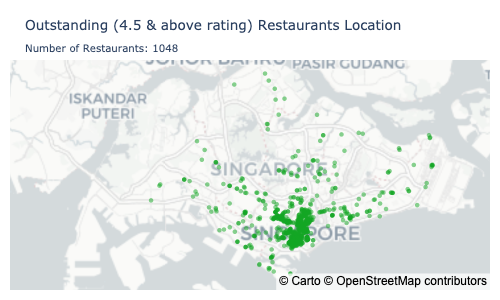

In [11]:
for i in [('Subpar', '3.5 & below','#fa6473'), ('Average', '4.0', '#C7970C'), ('Outstanding', '4.5 & above', '#12A623')]:
    gdf_subset = gdf_restaurant[gdf_restaurant['overall_rating_categorical'] == i[0]]
    fig = px.scatter_mapbox(
        gdf_subset,
        lat=gdf_subset.geometry.y,
        lon=gdf_subset.geometry.x,
        width=500,
        height=300,
        center= {
            'lat': 1.35,
            'lon': 103.8
        },
        range_color=(1,5),
        hover_data=['station_name', 'station_line_color'],
        zoom=9.4 # 11.2 for CBD
    )

    fig.update_traces(
        marker=dict(
            size=5,
            opacity=0.5,
            color=i[2]
        )
    )

    fig.update_layout(
        title= f"<span style='font-size:80%'>{i[0]} ({i[1]} rating) Restaurants Location </span><br><span style='font-size:60%;'>Number of Restaurants: {len(gdf_subset)}</span>",
        margin={'r': 10, 'l': 10, 'b': 10, 't': 60},
        mapbox_accesstoken=mapbox_token,
        mapbox= {'style': 'carto-positron'}
    )
    fig.show("png")

<strong>Observations:</strong>

- For restaurants of subpar, average and outstanding ratings, their geographical locations seem to be similarly distributed

### Walking Distance

In [12]:
np.corrcoef([
    gdf_restaurant['walking_distance'],
    gdf_restaurant['overall_rating']
])

array([[1.        , 0.00456993],
       [0.00456993, 1.        ]])

In [13]:
gdf_restaurant[gdf_restaurant['overall_rating_categorical'] == 'Subpar']['walking_distance'].describe()

count     1789.000000
mean       650.367021
std       1034.452855
min          0.400000
25%        205.300000
50%        364.200000
75%        715.300000
max      16227.800000
Name: walking_distance, dtype: float64

In [14]:
gdf_restaurant[gdf_restaurant['overall_rating_categorical'] == 'Average']['walking_distance'].describe()

count     2131.000000
mean       797.374349
std       1689.885095
min          0.400000
25%        242.200000
50%        398.900000
75%        793.600000
max      16700.100000
Name: walking_distance, dtype: float64

In [15]:
gdf_restaurant[gdf_restaurant['overall_rating_categorical'] == 'Outstanding']['walking_distance'].describe()

count     1048.000000
mean       592.870611
std       1011.027546
min          0.300000
25%        234.725000
50%        376.600000
75%        611.350000
max      16261.000000
Name: walking_distance, dtype: float64

Walking Distance has very little impact on overall rating

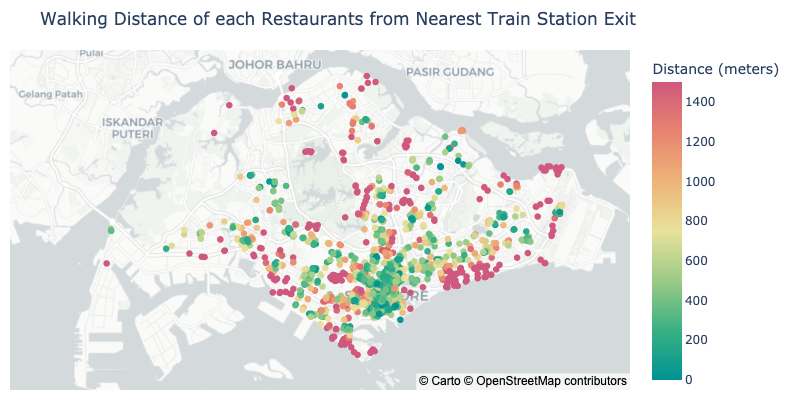

In [16]:
fig = px.scatter_mapbox(
    gdf_restaurant,
    lat=gdf_restaurant.geometry.y,
    lon=gdf_restaurant.geometry.x,
    color='walking_distance',
    # size='overall_rating',
    size_max=10,
    color_continuous_scale='temps',
    width=800,
    height=400,
    labels={
        "walking_distance": "Distance (meters)"
    },
    center= {
        'lat': 1.35,
        'lon': 103.8
    },
    range_color=(0,1500),
    hover_data=['station_name', 'station_line_color'],
    zoom=9.8 # 11.2 for CBD
)

fig.update_traces(
    marker=dict(
        size=7,
        # opacity=0.7
    )
)

fig.update_layout(
    title= "Walking Distance of each Restaurants from Nearest Train Station Exit",
    margin={'r': 10, 'l': 10, 'b': 10, 't': 50},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")
# fig.show()

- Restaurants located nearer to Coastal areas, such as East Coast Park and Sentosa, or Central Catchment areas have a longer walking distance
- Restaurants in CBD have low walking distance from the nearest train station

### Is-In Mall

In [17]:
gdf_restaurant.head(1)

,name,address,latitude,longitude,nearby_attraction,distance_from_attraction,num_of_rating_1,num_of_rating_2,num_of_rating_3,num_of_rating_4,...,walking_distance,walking_duration,station_name,station_line_color,distance,mall,is_in_mall,region,geometry,overall_rating_categorical
0,Alt Pizza,"60 Robertson Quay The Quayside 01-05, Singapor...",1.29026,103.83919,Chinatown,1.0,1,1,3,4,...,744.5,536.0,FORT CANNING MRT STATION,BLUE,602.90072,NaN,0.0,SINGAPORE RIVER,POINT (103.83919 1.29026),Average


In [18]:
df_mall = gdf_restaurant.groupby(['mall']).aggregate({'url': ['count'], 'overall_rating': ['mean']})
df_mall.columns = df_mall.columns.droplevel(1)
df_mall.reset_index(drop=False, inplace=True)
df_mall.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

In [19]:
df_mall.sort_values(by=['num_of_restaurants'], ascending=False)

,mall,num_of_restaurants,average_rating
97,Suntec City,65,3.676923
64,Marina Square,56,3.830357
81,Plaza Singapura,51,3.549020
47,Ion Orchard,48,3.739583
68,Ngee Ann City,44,3.738636
...,...,...,...
83,Punggol Plaza,1,4.500000
84,Queensway Shopping Centre,1,4.000000
12,Boon Lay Shopping Centre,1,4.000000
123,Wisteria Mall,1,4.000000


In [20]:
df_mall.sort_values(by=['average_rating'], ascending=False)

,mall,num_of_restaurants,average_rating
103,The Adelphi,1,5.000000
80,People'S Park Complex,2,4.750000
75,Palais Renaissance,7,4.571429
108,The Shoppes At Marina Bay Sands,1,4.500000
83,Punggol Plaza,1,4.500000
...,...,...,...
42,Hougang 1,2,3.000000
118,West Mall,3,2.833333
44,Hougang Mall,3,2.833333
51,Junction 10,1,2.000000


In [21]:
gdf_restaurant[gdf_restaurant['is_in_mall'] == True]['walking_distance'].describe()

count    1436.000000
mean      472.127228
std       522.801840
min         0.400000
25%       170.375000
50%       310.350000
75%       532.325000
max      3224.700000
Name: walking_distance, dtype: float64

In [22]:
gdf_restaurant[gdf_restaurant['is_in_mall'] == False]['walking_distance'].describe()

count     3532.000000
mean       794.469150
std       1561.044039
min          0.300000
25%        260.725000
50%        418.350000
75%        791.275000
max      16700.100000
Name: walking_distance, dtype: float64

In [23]:
gdf_restaurant[gdf_restaurant['is_in_mall'] == True]['overall_rating'].describe()

count    1436.000000
mean        3.739554
std         0.509214
min         1.000000
25%         3.500000
50%         4.000000
75%         4.000000
max         5.000000
Name: overall_rating, dtype: float64

In [24]:
gdf_restaurant[gdf_restaurant['is_in_mall'] == False]['overall_rating'].describe()

count    3532.000000
mean        3.923981
std         0.502145
min         1.000000
25%         3.500000
50%         4.000000
75%         4.000000
max         5.000000
Name: overall_rating, dtype: float64